In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import sys, os
sys.path.append("../core-scripts")
import Utilities
from Utilities import calc_scaled_diff, max_re

In [2]:
DATA_PATH = "./data/3D-shear-FULL-kx_0-4_kz0.6-M-170-190"

data = np.load(os.path.join(DATA_PATH, "spectra-mat.npy"))
gds = np.load(os.path.join(DATA_PATH, "gds.npy"))
kxs = np.load(os.path.join(DATA_PATH, "kxs.npy"))
acts = np.load(os.path.join(DATA_PATH, "acts.npy"))

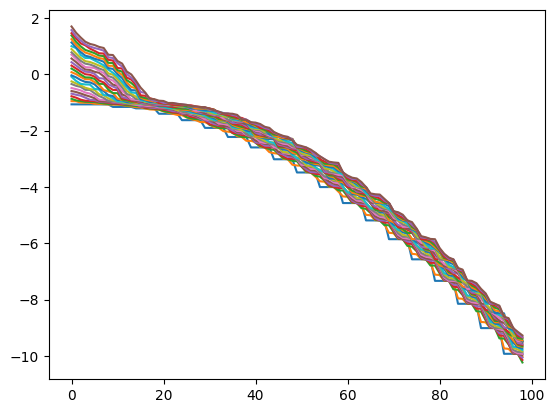

In [63]:
gd_idx = 2
k_idx = 2
for j in range(0, len(acts)):
    high_evals = data[k_idx,gd_idx,j,1,1:]
    plt.plot(high_evals.real, label=f"$a={np.round(acts[j],3)}$")
# plt.legend()

In [58]:
def real_err(ev1, ev2):
        # Only compare the 10 values near the pruning pointers
        return np.linalg.norm(ev1[:5].real - ev2[:5].real)

def extract_max_k(low_evals, high_evals):
    _, ptr1, ptr2 = Utilities.prune_evs(low_evals, high_evals)
    low_max, _ = Utilities.max_re(low_evals[ptr1:])
    high_max, _ = Utilities.max_re(high_evals[ptr2:])
    return Utilities.max_re(np.array([low_max, high_max]))[0]

def sift_evs(data_low, data_high):
    accepted = []
    diff_disp = []
    for i in range(len(data_low)-20):
        diffs = abs(data_low[i].real - data_high.real)
        amin = np.argmin(diffs)
        # print(amin, data_high[amin])
        if diffs[amin] < 0.01:
            displace_diff = np.linalg.norm(data_low[i:i+5].real - data_high[amin:amin+5].real)/5
            # print(i, amin, )
            accepted.append((i,amin))
            diff_disp.append(displace_diff)
    pair = ()
    for i in range(len(diff_disp)):
        if diff_disp[i]<1e-4:
            pair = accepted[i]
            break
    if len(pair)==0:
         return -1
    return Utilities.max_re(np.array([data_low[pair[0]], data_high[pair[1]]]))[0]
        
def extract_based_on_diff(low_ev, high_ev):
    diffs = np.diff(low_ev.real)
    start_idx = -1
    for i in range(len(low_ev)-2, -1, -1):
        if np.abs(diffs[i]) > 5:
            start_idx = i+1
            break
    nearest_delta = np.min(np.abs(low_ev[start_idx].real - high_ev.real))
    if not start_idx==-1:
        while nearest_delta>0.2:
            start_idx += 1
            nearest_delta = np.min(np.abs(low_ev[start_idx].real - high_ev.real))
    return 0 if start_idx==-1 else start_idx

def filter_scaled_diff(low_evals, high_evals, align_threshold=1e-3, abs_threshold=1e-2):
    """
        Takes in two calculations of the same spectrum and filters spurious, large eigenvalues
        at the start of the spectrum based on scaled differences.
        
        Returns the index below which all eigenvalues are ignored. (1 or 2)
    """
    d_o, d_n = calc_scaled_diff(low_evals, high_evals)
    # Measures the skill with which eigenvalues are resolved
    diff_diff = np.abs(d_o - d_n) # meaning "difference between the differences"
    
    # (Ignore the very first eigenvalue because it is almost always spurious)
    # If the first two eigenvalues are resolved with similar skill, then return the one with smaller error
    # otherwise, 
    if np.abs(diff_diff[1] - diff_diff[2])<1e-5:
        return np.argmin([d_o[1]+d_n[1], d_o[2]+d_n[2]])+1
    else:
        return np.argmin([diff_diff[1], diff_diff[2]])+1

In [107]:
spec_k = np.zeros((len(kxs), len(gds), len(acts)), dtype=np.complex128)
spec = np.zeros((len(gds), len(acts)), dtype=np.complex128)
sign_agree = np.zeros((len(gds), len(acts)))

for i in range(len(gds)):
    for j in range(len(acts)):
        for k in range(len(kxs)):
            low_evals = data[k,i,j,0,:]
            high_evals = data[k,i,j,1,:]
            # idx = filter_scaled_diff(low_evals, high_evals)
            # spec_k[k,i,j] = high_evals[idx]
            spec_k[k,i,j] = max_re(high_evals[2:])[0]

for i in range(len(gds)):
    for j in range(len(acts)):
        spec[i,j] = max_re(spec_k[:,i,j])[0]

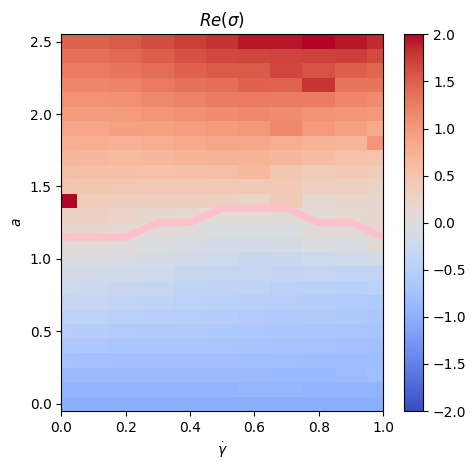

In [108]:
# fig, axs = plt.subplots(1,3)
# axs[0].imshow(spec.T.real>0, aspect=0.45, vmax = 1, origin='lower')
# axs[0].set_title("Stability Diagram")

fig = plt.figure() 

crit_acts_3D = np.zeros(len(gds))
crit_acts_3D_idx = np.zeros(len(gds))
for i in range(len(gds)):
    for j in range(len(acts)):
        if spec[i,j].real>0:
            crit_acts_3D[i] = (acts[j] + acts[j+1]) / 2
            crit_acts_3D_idx[i] = (2*j + 1) / 2
            break
        
evs_plot = plt.imshow(spec.T.real, aspect=0.45, vmin=-2, vmax=2, origin='lower', cmap='coolwarm')
plt.plot(np.arange(len(gds)), crit_acts_3D_idx, linewidth=5, c='pink')
plt.colorbar(evs_plot, fraction=0.046, pad=0.04)
plt.title("$Re(\sigma)$")
skip = 5
plt.xticks(np.arange(len(gds))[::2], np.round(gds[::2],1))
plt.yticks(np.arange(len(acts))[::5], np.round(acts[::5],1))
plt.xlabel("$\dot\gamma$")
plt.ylabel("$a$")
plt.xlim([0, len(gds)-1])

# sign_axs_plot = axs[2].imshow(sign_agree.T, aspect=0.45, origin='lower')
# plt.colorbar(sign_axs_plot, ax=axs[2],fraction=0.046, pad=0.04)

fig.set_figwidth(6)
plt.tight_layout()

### Plot scaled differences 
Q: Can we find a way to select eigenvalues based off of the scaled differences? 
A: Not really

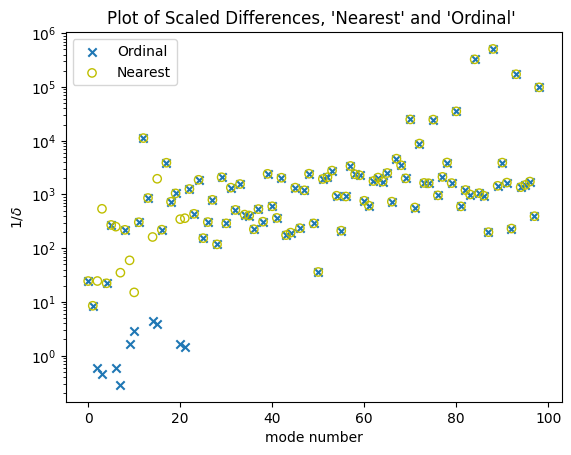

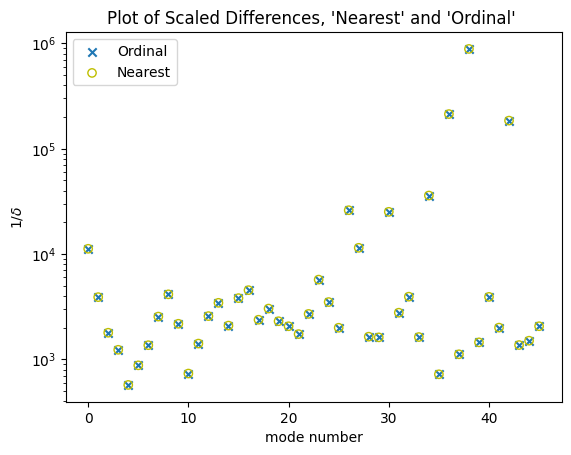

In [502]:
k,i,j = 4, 9, 9
low_evals = data[k,i,j,0,:]
high_evals = data[k,i,j,1,:]

fig, d_ordinal, d_nearest = Utilities.plot_scaled_diff(low_evals, high_evals)
diff_diff = np.abs(d_ordinal - d_nearest)
# print(d_ordinal)
valid_idx = np.where(np.logical_and(diff_diff<10e-5, d_ordinal<1e-3))
fig, d_ordinal, d_nearest = Utilities.plot_scaled_diff(low_evals[valid_idx], high_evals[valid_idx])
# fig ,axs = plt.subplots(1,2)
# colors = ["tomato", "salmon", "lightgreen", "darkseagreen", "steelblue", "lightsalmon", "darkblue"]
# START_IDX = 2
# for k in range(len(kxs)):
#     low_evals = data[k,i,j,0,:]
#     high_evals = data[k,i,j,1,:]
#     axs[0].plot(low_evals[START_IDX:10].real, c=colors[k], label=f"$k={np.round(kxs[k],2)}$")
#     axs[0].plot(high_evals[START_IDX:10].real, '--',  c=colors[k])
# # plt.plot(filter_scaled_diff(low_evals, high_evals).real, label='filtered')
# axs[1].plot(data[:,i,j,0,START_IDX].real, c="tomato", label="Low")
# axs[1].plot(data[:,i,j,1,START_IDX].real, c="steelblue", label="High")
# axs[1].set_xlabel("$k_x$")
# axs[1].legend()
# axs[0].legend()
# axs[0].set_xlabel("Mode Number")
# axs[0].set_ylabel("$Re(\sigma)$")
# fig.set_figwidth(8)

### Inspect $\sigma$ with respect to $k$

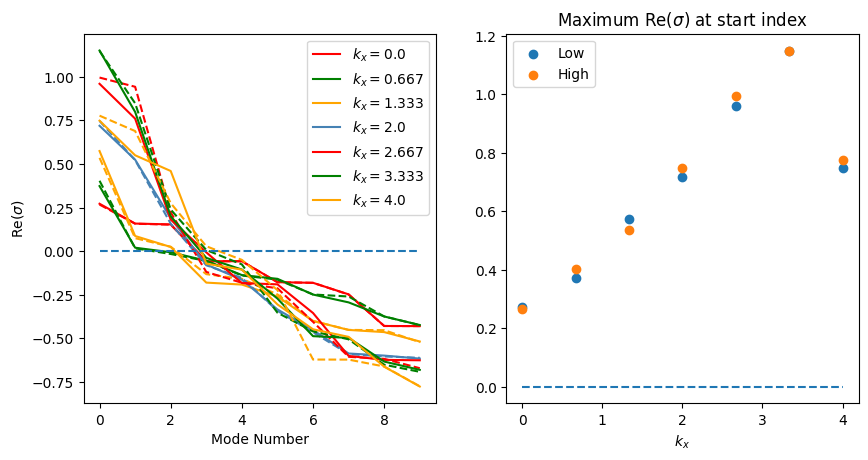

In [379]:
i,j = 7, 19 # shear and activity indices
start = 2 # how far into the spectrum to start the plot

cs = ['red', 'green', 'orange', 'steelblue']
fig, axs = plt.subplots(1,2)
for kk in range(0, len(kxs)):
    axs[0].plot(data[kk,i,j,0,start:start+10].real, c=cs[kk % 4], label=f'$k_x={np.round(kxs[kk],3)}$')
    axs[0].plot(data[kk,i,j,1,start:start+10].real, '--', c=cs[kk % 4])
axs[0].plot(np.zeros(10), '--')
axs[0].set_ylabel("Re($\sigma$)")
axs[0].set_xlabel("Mode Number")
axs[0].legend()

axs[1].scatter(kxs, data[:,i,j,0,start].real)
axs[1].scatter(kxs, data[:,i,j,1,start].real)
axs[1].plot(kxs, np.zeros(len(kxs)), '--')
axs[1].set_xlabel("$k_x$")
axs[1].legend(["Low", "High"])
axs[1].set_title("Maximum Re($\sigma$) at start index")
# axs[1].set_ylim([-2, 2])

fig.set_figwidth(10)

In [549]:
crit_acts_3D

array([1.15, 1.15, 1.15, 1.25, 1.35, 1.35, 1.35, 1.35, 1.35, 1.45, 1.35])

In [90]:
crit_acts_3D

array([1.15, 1.15, 1.15, 1.25, 1.25, 1.35, 1.35, 1.35, 1.25, 1.25, 1.15])